In [1]:
#!pip3 install --user astropy
#!pip3 install --user kaleido

In [132]:
import numpy as np
import astropy as ap
import pandas as pd
from astropy.io import fits
import scipy.linalg as slg
from scipy.stats import norm
import scipy.stats
from math import ceil
import csv

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
import kaleido

# import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# from matplotlib.colors import LinearSegmentedColormap
import glob
import os
# These are in Functions
from os.path import join as pj
# from os.path import abspath as absp

from IPython.display import Image
from IPython.display import display

from joblib import Parallel, delayed

import PIL
import pickle

import sys
from collections import namedtuple as nt

In [3]:
os.environ["SPARCFIRE_HOME"] = "/home/portmanm/sparcfire_matt/"

_HOME_DIR = os.path.expanduser("~")
try:
    _SPARCFIRE_DIR = os.environ["SPARCFIRE_HOME"]
    _MODULE_DIR = pj(_SPARCFIRE_DIR, "GalfitModule")
except KeyError:
    if __name__ == "__main__":
        print("SPARCFIRE_HOME is not set. Please run 'setup.bash' inside SpArcFiRe directory if not done so already.")
        print("Checking the current directory for GalfitModule, otherwise quitting.")
            
        _MODULE_DIR = pj(os.getcwd(), "GalfitModule")
        
        if not exists(_MODULE_DIR):
            raise Exception("Could not find GalfitModule!")
    
sys.path.append(_MODULE_DIR)
from Classes.Components import *
from Classes.Containers import *
from Classes.FitsHandlers import *
from Functions.helper_functions import *

all_results = nt("all_results", ["full_df", "success_df", "not_success_df", "by_eye_success_df", "by_eye_not_success_df"])

In [5]:
# # Defunct
# def check_galfit_chi(gal_name, base_path):
#     # An example line
#     # # Chi^2/nu = 4.661,  Chi^2 = 12025.575,  Ndof = 2580
    
#     #galfit_txt_out = "galfit.01" # in the future galfit.01 may change
#     filename = os.path.join(base_path, gal_name, galfit_txt_out)
#     with open(filename, "r") as f:
#         for line in f:
#             if "Chi" in line:
#                 chi_line = line.strip("# ")
    
#     # This also works but it's quite devious...
#     # chi_line.replace("^", "").replace("/", "_").replace(",  ", "\n").lower()
#     # exec(chi_line)
    
#     out_vals = chi_line.split(",")
#     chi2_nu = float(out_vals[0].strip().split("=")[-1])
#     chi2 = float(out_vals[1].strip().split("=")[-1])
#     ndof = int(out_vals[2].strip().split("=")[-1])
    
#     return chi2_nu, chi2, ndof

In [ ]:
def get_total_galaxies(in_dir = "sparcfire-in", out_dir = "sparcfire-out"):   
    all_gnames_in  = find_files(in_dir, "123*", "f")
    all_gnames_out = find_files(out_dir, "123*", "d")
    total_galaxies = min(len(all_gnames_in), len(all_gnames_out))
    if not total_galaxies:
        total_galaxies  = max(len(all_gnames_in), len(all_gnames_out))
        
    return total_galaxies

In [ ]:
def load_residual_df(out_dir, basename, method = "nmr_x_1-p", verbose = True):
    
    pickle_filename = pj(out_dir, basename, sorted(find_files(pj(out_dir, basename), f'{basename}_output_results*.pkl', "f"))[-1])
    
    residual_df  = pd.read_pickle(pickle_filename)
    # temp_df = deepcopy(residual_df)
    # Setting residual columns
    #residual_df["KS_P"] = 1 - residual_df["KS_P"]
    if method == "nmr_x_1-p":
        result_of_method = (1 - residual_df["KS_P"])*residual_df["NMR"]
    elif method == "nmr_neg_log":
        result_of_method = residual_df["NMR"]/-np.log(residual_df["KS_P"] + 1e-10)
    elif method == "W_quality":
        result_of_method = residual_df["KS_P"]/residual_df["W_NMR"]
    else:
        raise Exception(f"Method given: {method} is not a valid method (yet).")
    
    residual_df[method] = result_of_method
    
    # Valid meaning NMR was successfully calculated
    #cols_to_drop = [col for col in residual_df.columns if col.endswith("_sky_2")]
    #valid_spiral_df = residual_df.drop(columns = cols_to_drop).dropna()

    # rename sky_2 to sky_3 for non-spirals to be inline with everything else
    # this would be for potential comparison down the line
    cols_to_merge = [col for col in residual_df.columns if col.endswith("_sky_3") or col.endswith("_sky_4")]
    #_ = [residual_df[col].fillna(residual_df[f"{col[:-1]}2"], inplace = True) for col in cols_to_merge]
    cols_to_drop  = [col for col in residual_df.columns if col.endswith("_sky_2") or col.endswith("_sky_3")]#  + ["KS_STAT"]
    residual_df.drop(columns = cols_to_drop, inplace = True)
    
    if verbose:
        print(f"{len(residual_df)} galaxy models generated.")
    
    return residual_df

In [ ]:
def load_galaxy_csv(out_dir, basename, pre_post):
    
    field = " pa_alenWtd_avg_domChiralityOnly"
    # {basename}_ uneccessary because different *galfit* runs 
    # should have same sparcfire output
    fname = pj(out_dir, basename, f"{basename}_{pre_post}_galfit_galaxy.csv")
    sparc_output_csv = pd.read_csv(fname, #pj(out_dir, f"pre_galfit_galaxy.csv"),
                                       index_col = "name",
                                       on_bad_lines = "warn",
                                       usecols   = ["name", field], # , " iptSz"],
                                       #na_values = "NaN",
                                       #dtype     = {field : float} #, " iptSz" : str}#, "name" : str}
                                      )#.loc[:, field]
    #sparc_output_csv.index.name = None
    sparc_output_csv[field] = sparc_output_csv[field].astype(float)
    sparc_output_csv.index = sparc_output_csv.index.map(str)
    #sparc_output_csv[" iptSz"] = sparc_output_csv[" iptSz"].str.extract(r"([0-9]+)").astype(float)

    #sparc_output_csv["pre_sign"] = np.sign(sparc_output_csv[field])
    sparc_output_csv.rename(columns = {field : f"galaxy_{pre_post}_pa"}, inplace = True)
    
    return sparc_output_csv

In [ ]:
def load_galaxy_arcs_csv(out_dir, basename, pre_post, **kwargs):
    
    field_pa   = kwargs.get("field_pa"  , "pitch_angle")
    field_alen = kwargs.get("field_alen", "arc_length")
    name_col   = kwargs.get("name_col"  , "gxyName")

    fname = pj(out_dir, basename, f"{basename}_{pre_post}_galfit_galaxy_arcs.csv")
    sparc_output_arcs_csv = pd.read_csv(fname, 
                                       index_col = name_col,
                                       usecols   = [name_col, field_pa, field_alen],
                                       dtype     = {field_pa : float, field_alen : float} #, name_col : str}
                                      )#.loc[:, field]
    #sparc_output_csv.index.name = None
    sparc_output_arcs_csv.index = sparc_output_arcs_csv.index.map(str)

    # Filtering for pure circles and near circles
    sparc_output_arcs_csv = sparc_output_arcs_csv[abs(sparc_output_arcs_csv[field_pa ]) > 1]

    #sparc_output_arcs_csv = pd.concat([sparc_output_arcs_csv, pre_sparc_output_csv], axis = 1)
    #sparc_output_arcs_csv["sign"] = np.sign(sparc_output_arcs_csv[field])

    # Keeps only arms which align with dom chirality only
    # sparc_output_arcs_csv["check"] = [
    #     row["sign"] + pre_sparc_output_csv.loc[i, "pre_sign"] 
    #     if i in pre_sparc_output_csv.index 
    #     else None 
    #     for i, row in sparc_output_arcs_csv.iterrows()
    # ]

    #sparc_output_arcs_csv = sparc_output_arcs_csv[abs(sparc_output_arcs_csv.loc[:, "check"]) == 2].drop(columns = ["sign", "check"])
    sparc_output_arcs_top3 = sparc_output_arcs_csv.groupby(name_col).head(3).reset_index()
    sparc_output_arcs_top3[f"{pre_post}_sign"] = np.sign(sparc_output_arcs_top3.pitch_angle)

    dom_sign = np.sign(sparc_output_arcs_top3.groupby(name_col).sum()[f"{pre_post}_sign"])
    sparc_output_arcs_top3 = sparc_output_arcs_top3.join(dom_sign, rsuffix = "_dom", on = name_col)

    cond = sparc_output_arcs_top3[f"{pre_post}_sign_dom"] == sparc_output_arcs_top3[f"{pre_post}_sign"]
    sparc_output_arcs_top2 = sparc_output_arcs_top3[cond].groupby(name_col).head(2).reset_index().drop(columns = [f"{pre_post}_sign_dom", "index"])

    #pre_sparc_output_top2.rename(columns = {field : "pre_pa"}, inplace = True)
    #pre_sparc_output_csv.dropna(inplace=True)
    return sparc_output_arcs_top2

In [ ]:
def prepare_arcs_output(sparc_output_arcs_top2, pre_post, **kwargs):
    
    field_pa   = kwargs.get("field_pa"  , "pitch_angle")
    field_alen = kwargs.get("field_alen", "arc_length")
    name_col   = kwargs.get("name_col"  , "gxyName")
    
    single_arm = sparc_output_arcs_top2[~sparc_output_arcs_top2.duplicated(name_col, keep = False)]
    single_arm.loc[:, field_pa] = 0
    #single_arm.loc[:, "arc_length"]  = 0

    filled_in = pd.concat([sparc_output_arcs_top2, single_arm], ignore_index = True)
    str_fill = [f"{pre_post}_pa1", f"{pre_post}_pa2"] * (len(filled_in) // 2)
    filled_in["temp1"] = str_fill

    str_fill = [f"{pre_post}_alen1", f"{pre_post}_alen2"] * (len(filled_in) // 2)
    filled_in["temp2"] = str_fill

    #filled_in = filled_in.reset_index().drop(columns = ["index"])
    sp_out = filled_in.pivot_table(index = name_col, columns = ["temp1", "temp2"], values = [field_pa, field_alen])

    sp_out = sp_out.droplevel(0, axis = 1).droplevel(0, axis = 1)
    sp_out.columns = [f'{pre_post}_alen1', f'{pre_post}_alen2', f'{pre_post}_pa1', f'{pre_post}_pa2']
    
    return sp_out

In [ ]:
def before_after_galfit_comparison(all_sparc_out, pre_sparc_output_csv, post_sparc_output_csv):
    
    before_after_galfit_df = deepcopy(all_sparc_out)#.dropna() #full_df.dropna(subset = ["post_pa"])
    #before_after_galfit_df = before_after_galfit_df[np.sign(before_after_galfit_df.loc[:, "pre_pa"]) != np.sign(before_after_galfit_df.loc[:, "post_pa"])]

    before_after_galfit_df["chiral_agreement"] = np.sign(before_after_galfit_df["pre_pa1"]) == np.sign(before_after_galfit_df["post_pa1"])

    before_after_galfit_df["pre_pa1"]  = abs(before_after_galfit_df["pre_pa1"])
    before_after_galfit_df["pre_pa2"]  = abs(before_after_galfit_df["pre_pa2"])
    before_after_galfit_df["post_pa1"] = abs(before_after_galfit_df["post_pa1"])
    before_after_galfit_df["post_pa2"] = abs(before_after_galfit_df["post_pa2"])


    before_after_galfit_df["1-1"] = abs(before_after_galfit_df["pre_pa1"] - before_after_galfit_df["post_pa1"])
    before_after_galfit_df["2-2"] = abs(before_after_galfit_df["pre_pa2"] - before_after_galfit_df["post_pa2"])
    before_after_galfit_df["1-2"] = abs(before_after_galfit_df["pre_pa1"] - before_after_galfit_df["post_pa2"])
    before_after_galfit_df["2-1"] = abs(before_after_galfit_df["pre_pa2"] - before_after_galfit_df["post_pa1"])

    before_after_galfit_df["mean-1122"]  = before_after_galfit_df[["1-1","2-2"]].mean(axis = "columns")
    before_after_galfit_df["mean-1221"]  = before_after_galfit_df[["1-2","2-1"]].mean(axis = "columns")

    before_after_galfit_df["min_diff"]   = before_after_galfit_df[["mean-1122", "mean-1221"]].min(axis = 1)

    before_after_galfit_df["best_diffs"] = [
        (row["1-1"], row["2-2"]) if np.mean((row["1-1"], row["2-2"])) == row["min_diff"] 
        else (row["1-2"], row["2-1"]) 
        for _, row in before_after_galfit_df.iterrows()
    ]

    before_after_galfit_df["pa_diff1"], before_after_galfit_df["pa_diff2"] = zip(*before_after_galfit_df["best_diffs"])
    #before_after_galfit_df["best_diff2"] = [row["2-2"] if np.mean((row["1-1"], row["2-2"])) == row["min_diff"] else row["2-1"] for _, row in before_after_galfit_df.iterrows()]
    before_after_galfit_df["pa_diff_galaxy"] = abs(abs(post_sparc_output_csv["galaxy_post_pa"]) - abs(pre_sparc_output_csv["galaxy_pre_pa"]))# < 15

    # min(2_arm_length)/max(2_arm_length) > 0.7, verify that this is valid by eye
    #before_after_galfit_df["alen_ratio"] = post_sparc_output_csv[" iptSz"]*before_after_galfit_df[["pre_alen1", "pre_alen2"]].min(axis = 1)/(pre_sparc_output_csv[" iptSz"]*before_after_galfit_df[["post_alen1", "post_alen2"]].max(axis = 1))
    before_after_galfit_df["alen_ratio"] = before_after_galfit_df[["post_alen1", "post_alen2"]].min(axis = 1)/before_after_galfit_df[["post_alen1", "post_alen2"]].max(axis = 1)
    #before_after_galfit_df.drop(columns = ["pre_sign", "post_sign"], inplace = True)

    # before_after_galfit_df.loc[:, "within_15_degrees_pre"]  = before_after_galfit_df.loc[:, "diff_pre"] < 15
    # before_after_galfit_df.loc[:, "within_15_degrees_post"] = before_after_galfit_df.loc[:, "diff_post"] < 15
    #before_after_galfit_df.sort_values(by = ["post_pa"])
    before_after_galfit_df = before_after_galfit_df.drop(columns = before_after_galfit_df.columns[9:-4])
    
    return before_after_galfit_df

In [ ]:
def gather_everything(residual_df, before_after_galfit_df):
    full_df = residual_df.join(before_after_galfit_df)
    full_df = full_df[full_df.index.notnull()].sort_values(by = method)

    full_df.dropna(subset = ["pa_diff1", "pa_diff2", "pa_diff_galaxy"], how = "all", inplace = True)
    full_df["min_pa_diff"] = full_df[["pa_diff1", "pa_diff2", "pa_diff_galaxy"]].min(axis = 1)
    
    return full_df

In [ ]:
def determine_success(full_df, in_dir = "sparcfire-in", out_dir = "sparcfire-out", verbose = True, flip_chiral_agreement = False):
    cutoff_val = 0.007
    residual_cutoff = full_df["nmr_x_1-p"] <= cutoff_val
    #pa_cutoff = (full_df["pa_diff1"] < 10) | (full_df["pa_diff2"] < 10)
    pa_cutoff   = full_df["min_pa_diff"] < 10
    alen_cutoff = full_df["alen_ratio"] > 0.5 #[True]
    sign_cutoff = full_df["chiral_agreement"].astype(bool)
    if flip_chiral_agreement:
        sign_cutoff = ~sign_cutoff

    success_df     = full_df[residual_cutoff & pa_cutoff & alen_cutoff & sign_cutoff]
    not_success_df = full_df[~(residual_cutoff & pa_cutoff & alen_cutoff & sign_cutoff)]
    
    if verbose:
        print(f"{len(full_df)} processed by sparcfire")
        print(f"{sum(residual_cutoff)} pass residual cutoff")
        print(f"{sum(pa_cutoff)} pass pitch angle cutoff")
        print(f"{sum(alen_cutoff)} pass arm length ratio cutoff")
        print(f"{sum(sign_cutoff)} pass chiral agreement")
        print(f"{len(success_df)} or {100*len(success_df)/len(full_df):.2f}% ({len(success_df)}/{len(full_df)}) succeed by SpArcFiRe metric")
        print(f"{total_galaxies - len(full_df)}/{total_galaxies} models failed reprocessing by SpArcFiRe")
        
        #print(f"Total success less 24% false positive -- {len(success_df)*.76:.0f}")
        #print(f"Total success less 24% false positive + 24% false negative -- {len(not_success_df)*0.24+len(success_df)*.76:.0f}")
        #print(f"Estimated total success % -- {100*(len(not_success_df)*0.24+len(success_df)*.76)/len(full_df):.0f}%")
    
    return success_df, not_success_df

In [ ]:
def extract_by_eye_data(out_dir, basename, residual_df, full_df, subset = None,  verbose = True):
    
    with open(f"{pj(out_dir, basename, basename)}_by-eye_success.txt", "r") as f:
        raw_by_eye_success_galaxies = [i.split("_")[0].strip() for i in f.readlines()]

    with open(f"{pj(out_dir, basename, basename)}_by-eye_not_success.txt", "r") as f:
        raw_by_eye_not_success_galaxies = [i.split("_")[0].strip() for i in f.readlines()]
        
    by_eye_success_galaxies = [i for i in raw_by_eye_success_galaxies if i in full_df.index]
    by_eye_not_success_galaxies = [i for i in raw_by_eye_not_success_galaxies if i in full_df.index]
    
    if verbose:
        
        total = len(residual_df)
        if subset:
            total = subset
            print(f"Working on a subset of {total} galaxies")
            
        align = len(f"{len(by_eye_success_galaxies)}/{len(raw_by_eye_success_galaxies)}")
        print(f"Number of *total* by eye successful galaxies")
        print(f"{len(raw_by_eye_success_galaxies):<{align}} => {len(raw_by_eye_success_galaxies)/total*100:.2f}%")
        print(f"Number of by eye successful galaxies that SpArcFiRe *could* process")
        print(f"{len(by_eye_success_galaxies)}/{len(raw_by_eye_success_galaxies)} => {len(by_eye_success_galaxies)/len(raw_by_eye_success_galaxies)*100:.2f}%")
        
        print()
        
        align = len(f"{len(by_eye_not_success_galaxies)}/{len(raw_by_eye_not_success_galaxies)}")
        print(f"Number of *total* by eye not successful galaxies")
        
        print(f"{len(raw_by_eye_not_success_galaxies):<{align}} => {len(raw_by_eye_not_success_galaxies)/total*100:.2f}%")
        print(f"Number of by eye not successful galaxies that SpArcFiRe *could* process")
        print(f"{len(by_eye_not_success_galaxies)}/{len(raw_by_eye_not_success_galaxies)} => {len(by_eye_not_success_galaxies)/len(raw_by_eye_not_success_galaxies)*100:.2f}%")
    
    return by_eye_success_galaxies, by_eye_not_success_galaxies

In [ ]:
def calculate_false_positive_negative(
    by_eye_success_galaxies, 
    by_eye_not_success_galaxies, 
    success_df, 
    not_success_df, 
    full_df,
    verbose = True
):
    
    false_positive = set(by_eye_not_success_galaxies).intersection(set(success_df.index))
    false_negative = set(by_eye_success_galaxies).intersection(set(not_success_df.index))

    by_eye_success_df     = full_df.loc[by_eye_success_galaxies].sort_values(by = method)
    by_eye_not_success_df = full_df.loc[by_eye_not_success_galaxies].sort_values(by = method)

    FP_rate = f"{len(false_positive)}/({len(false_positive)} + {len(by_eye_not_success_df)})"
    FN_rate = f"{len(false_negative)}/({len(false_negative)} + {len(by_eye_success_df)})"

    if verbose:
        print(f"False positive rate (by eye) -- {FP_rate} = {100*eval(FP_rate):.2f}%")
        print(f"False negative rate (by eye) -- {FN_rate} = {100*eval(FN_rate):.2f}%")

    #print(f"Total # of galaxies sorted by eye -- {len(raw_by_eye_success_galaxies) + len(raw_by_eye_not_success_galaxies)}")
    return by_eye_success_df, by_eye_not_success_df, FP_rate, FN_rate

In [ ]:
def main(
    in_dir = "sparcfire-in", 
    out_dir = "sparcfire-out", 
    basename = "", 
    method = "nmr_x_1-p", 
    flip_chiral_agreement = False,
    incl_by_eye = True,
    by_eye_subset = None
):
    
    residual_df = load_residual_df(out_dir, basename, method = method)
    
    # field_pa   = "pitch_angle"
    # field_alen = "arc_length"
    # name_col   = "gxyName"

    pre_sparc_output_csv        = load_galaxy_csv(out_dir,      basename, pre_post = "pre")
    pre_sparc_output_arcs_top2  = load_galaxy_arcs_csv(out_dir, basename, pre_post = "pre")

    post_sparc_output_csv       = load_galaxy_csv(out_dir,      basename, pre_post = "post")
    post_sparc_output_arcs_top2 = load_galaxy_arcs_csv(out_dir, basename, pre_post = "post")

# ====================================================================================================================

    pre_sp_out    = prepare_arcs_output(pre_sparc_output_arcs_top2,  pre_post = "pre")
    post_sp_out   = prepare_arcs_output(post_sparc_output_arcs_top2, pre_post = "post")

    all_sparc_out = pd.concat([pre_sp_out, post_sp_out], axis = 1)
    
# ====================================================================================================================

    before_after_galfit_df     = before_after_galfit_comparison(
        all_sparc_out, 
        pre_sparc_output_csv, 
        post_sparc_output_csv
    )
    
    full_df                    = gather_everything(residual_df, before_after_galfit_df)
    
    success_df, not_success_df = determine_success(full_df, in_dir = in_dir, out_dir = out_dir, flip_chiral_agreement = flip_chiral_agreement)
    
    full_df["success"] = full_df.index.isin(success_df.index)
    print()
    
# ====================================================================================================================
    
    by_eye_success_df     = None
    by_eye_not_success_df = None
    
    if incl_by_eye:
        by_eye_success_galaxies, by_eye_not_success_galaxies = extract_by_eye_data(out_dir, basename, residual_df, full_df, subset = by_eye_subset)
        print()

        # To resolve an occasional processing error...
        by_eye_success_limited     = list(set(by_eye_success_galaxies).intersection(full_df.index))
        by_eye_not_success_limited = list(set(by_eye_not_success_galaxies).intersection(full_df.index))

        by_eye_success_df, by_eye_not_success_df, FP_rate, FN_rate = calculate_false_positive_negative(
            by_eye_success_limited, 
            by_eye_not_success_limited, 
            success_df, 
            not_success_df, 
            full_df
        )

        full_df["by_eye_success"] = full_df.index.isin(by_eye_success_df.index)
    
    return all_results(full_df, success_df, not_success_df, by_eye_success_df, by_eye_not_success_df)

In [ ]:
# EXAMPLE
if __name__ == "__main__":
    run_path = "testing_python_control" #os.getcwd()
    
    if in_notebook():
        run_path = run_path.replace("ics-home", "portmanm")

    in_dir  = pj(run_path, "sparcfire-in")
    out_dir = pj(run_path, "sparcfire-out")
    tmp_dir = pj(run_path, "sparcfire-tmp")
    
    global total_galaxies
    total_galaxies = get_total_galaxies(in_dir = in_dir, out_dir = out_dir)

    paper_image_dir = "for_paper_images"
    nmr             = "norm_masked_residual"
    method          = "nmr_x_1-p"

In [ ]:
if __name__ == "__main__":
    # full_df, success_df, not_success_df, by_eye_success_df, by_eye_not_success_df
    full_residual_results = main(in_dir = in_dir, out_dir = out_dir, basename = "full_residual", method = method)

In [ ]:
if __name__ == "__main__":
    # full_df, success_df, not_success_df, by_eye_success_df, by_eye_not_success_df
    bulge_n_4_results = main(in_dir = in_dir, out_dir = out_dir, basename = "bulge_n-4", method = method, flip_chiral_agreement = True)

In [ ]:
def combine_multi_run_results(method, *args, df_names = [], verbose = True):
    print(f"Joining {len(args)} attempts...")
    primary_full_df = deepcopy(args[0].full_df)
    
    num_dfs = len(args)
    #alt_full_df     = deepcopy(args[1].full_df)
    #alt_full_df.rename(columns = {method : f"1_{method}"}, inplace = True)

    all_full_dfs = [primary_full_df]
    all_methods  = [method]
    
    for i, arg in enumerate(args[1:]):
        alt_method = f"{i}_{method}"
        all_methods.append(alt_method)
        all_full_dfs.append(arg.full_df.rename(columns = {method : alt_method}))

    # BY RESIDUAL
    #temp_bool_df = pd.concat([primary_full_df[method], alt_full_df[f"1_{method}"]], axis = 1)
    combined_bool_df = pd.concat([df[method] for df, method in zip(all_full_dfs, all_methods)], axis = 1)

    #combined_bool_df.drop(index = list(set(primary_full_df.index).difference(set(alt_full_df.index))), inplace = True)
    #temp_bool_df["minima"] = temp_bool_df.idxmin(axis = 1)
    combined_bool_df["minima"] = combined_bool_df.idxmin(axis = 1)
    
    #og_minima  = temp_bool_df.minima == method
    #alt_minima = temp_bool_df.minima == f"1_{method}"
    minima_conditions = [combined_bool_df.minima == method for method in all_methods]
    
    #og_success = temp_bool_df.index.isin(args[0].by_eye_success_df.index)
    #alt_success = temp_bool_df.index.isin(args[1].by_eye_success_df.index)
    #print(sum((og_minima & og_success) | (alt_minima & alt_success)))
    
    by_eye_success_conditions = [combined_bool_df.index.isin(df.by_eye_success_df.index) for df in args]

    all_conditions = zip(minima_conditions, by_eye_success_conditions)
    list_o_conditions = [cond_set[0] & cond_set[1] for cond_set in all_conditions]
    eval_str = " | ".join([f"list_o_conditions[{i}]" for i in range(num_dfs)])
    
    combined_bool_df["residual_minima_success"] = eval(eval_str) 
    # print(sum((minima_conditions[0] & by_eye_success_conditions[0]) | (minima_conditions[1] & by_eye_success_conditions[1])))
    # print(sum(list_o_conditions[0] | list_o_conditions[1]))

    # By everything

    eval_str = " | ".join([f"all_full_dfs[{i}].success" for i in range(num_dfs)])
    combined_bool_df["by_sparcfire_success"] = eval(eval_str) #primary_full_df.success | alt_full_df.success # | combined_bool_df.residual_minima_success

    #eval_str = " | ".join([df.success for df in all_df])
    combined_bool_df["by_minima_and_sparcfire_success"] = combined_bool_df.by_sparcfire_success | combined_bool_df.residual_minima_success
    
    # by eye success for all labeled by df
    best_fit_str_dict = {m : f"df_{i}" for i, m in enumerate(all_methods)}
    combined_bool_df["best_fit"] = None
    
    for gname, row in combined_bool_df.iterrows():
        best_method = [
            (m, full_df.loc[gname, "by_eye_success"]) 
            for m, full_df in zip(all_methods, all_full_dfs)
            if gname in full_df.index and full_df.loc[gname, "by_eye_success"]
        ]
                
        if len(best_method) > 1:
            best_method = [(row.minima, None)]
            
        elif not best_method:
            best_method = [(None, None)]
        
        if not combined_bool_df.loc[gname, "best_fit"]:
            combined_bool_df.loc[gname, "best_fit"] = best_fit_str_dict.get(best_method[0][0], None)

    #eval_str = " | ".join([f"all_full_dfs[{i}].by_eye_success" for i, _ in enumerate(all_full_dfs)])
    #combined_bool_df["by_eye_success"] = eval(eval_str) #primary_full_df.by_eye_success | alt_full_df.by_eye_success
    combined_bool_df["by_eye_success"] = False | combined_bool_df.best_fit.str.contains("df")
    
    if df_names:
        if len(df_names) != num_dfs: 
            print("Length of dataframe names supplied should be equal to the number of dataframes supplied.")
            print("Leaving current convention in the dataframe (df_0, df_1, ..., df_n)")
        else:
            combined_bool_df["best_fit"]   = combined_bool_df.best_fit.replace({f"df_{i}" : name for i, name in enumerate(df_names)})
    
    if verbose:
        print(f"Total success by best score: {sum(combined_bool_df.residual_minima_success)}/{total_galaxies}")
        print(f"Total success by SpArcFiRe: {sum(combined_bool_df.by_sparcfire_success)}/{total_galaxies}")
        print(f"Total success by SpArcFiRe and best score: {sum(combined_bool_df.by_minima_and_sparcfire_success)}/{total_galaxies}")
        print(f"Total success by eye: {sum(combined_bool_df.by_eye_success)}/{total_galaxies}")
        print()
        
        bss  = set(combined_bool_df[combined_bool_df["by_sparcfire_success"]].index)
        TP   = set(combined_bool_df[combined_bool_df["by_eye_success"]].index)
        bsns = set(combined_bool_df[~combined_bool_df["by_sparcfire_success"]].index)
        TN   = set(combined_bool_df[~combined_bool_df["by_eye_success"]].index)
        
        FP   = bss.intersection(TN)
        FN   = bsns.intersection(TP)
        
        sparc_positive = bss.intersection(TP)
        fraction = len(sparc_positive)/sum(combined_bool_df.by_eye_success)
        # FPR = FP/(FP + TN)
        # FNR = FN/(FN + TP)
        print(f"By eye success found by SpArcFiRe+score:  {len(sparc_positive)}/{sum(combined_bool_df.by_eye_success)} = {100*fraction:.2f}%")
        FP_rate = f"{len(FP)} / ({len(FP)} + {len(TN)})"
        FN_rate = f"{len(FN)} / ({len(FN)} + {len(TP)})"

        print(f"False positive rate (by eye) -- {FP_rate} = {100*eval(FP_rate):.2f}%")
        print(f"False negative rate (by eye) -- {FN_rate} = {100*eval(FN_rate):.2f}%")
    
    #combined_success_df = pd.concat
    
    return combined_bool_df

In [ ]:
if __name__ == "__main__":
    combined_bool_df = combine_multi_run_results(
        method, 
        bulge_n_4_results, 
        full_residual_results,
        df_names = ["bule_n_4", "full_residual"]
    )

In [41]:
#success_dir = pj(out_dir, 'galfit_png')
success_dir = pj(out_dir, f'{basename}_galfit_png')
quantile = ["0", "20", "40", "60", "80"]
for q in quantile:
    temp_str = "{images/1000_galaxies/quantile_"
    initial_str = f"\includegraphics[height=0.19\\textheight]{temp_str}{q}/"
    end_str = "} &"
    for count, i in enumerate(by_eye_success_df[method][by_eye_success_df[method] >= by_eye_success_df[method].quantile(0.01*float(q), interpolation='lower')].items()):
        #if count < 5:
        #    continue
        if count == 8:
            break
        
        if count == 7:
            end_str = "} \\\\"
            
        gname = i[0]
        #print(q, i)
        print(f"{initial_str}{gname + '_combined.png'}{end_str}")
        #sp(f"cp {pj(success_dir, gname + '_combined.png')} {pj(success_dir, 'all_quantile', 'quantile_' + q)}")
        #sp(f"cp {pj(out_dir, 'by_eye_success', gname + '_combined.png')} {pj(success_dir, 'all_quantile', 'quantile_' + q)}")

0 ('1237667485918560560', 0.0007797300000000003)
0 ('1237671262273405158', 0.00109164)
0 ('1237668494708506733', 0.0011923599999999997)
0 ('1237671931209646271', 0.0012563200000000002)
0 ('1237680240907124849', 0.0013035599999999998)
0 ('1237678617433342002', 0.0013067999999999999)
0 ('1237673704506130531', 0.0013611900000000002)
0 ('1237671139873915058', 0.00224)
20 ('1237668350285578377', 0.0044)
20 ('1237671690689380567', 0.0044)
20 ('1237667782849069253', 0.00442225)
20 ('1237668350288527631', 0.00442845)
20 ('1237668349757489490', 0.0044347499999999995)
20 ('1237667783363133535', 0.0044556)
20 ('1237667448346050677', 0.00445584)
20 ('1237668625164140743', 0.0044621800000000005)
40 ('1237671124294631633', 0.0047922)
40 ('1237671124841529554', 0.0048)
40 ('1237668495245508656', 0.00480396)
40 ('1237679338960453694', 0.00482735)
40 ('1237668331489591443', 0.00484398)
40 ('1237668271904588024', 0.004856500000000001)
40 ('1237671261737582774', 0.00488922)
40 ('1237667549809672337', 0.0

In [ ]:
#success_df[success_df.sort_values(by = method)["alen_ratio"] == 1].index

In [ ]:
#plot_df.sort_values(by = ["diff_pre_post", "nmr_x_1-p"]).iloc[:20, :]

In [66]:
def create_ecdf(x, runname, df, dict_o_kwargs):
    
    # for key, default in exec_kwargs().items():
    #     exec(f"{key} = kwargs.get({key}, {default})")
    # Yeesh https://stackoverflow.com/a/67367191
    # Use frame(2) since these functions are nested
    sys._getframe(2).f_locals.update(dict_o_kwargs)

    fig = px.ecdf(df,
                  x = x,
                  markers = True, 
                  lines = False, 
                  marginal = "histogram",
                  ecdfnorm = None,
                  log_x    = log_x,
                  log_y    = log_y
                 ) 

    if add_vline:
        fig.add_vline(x = cutoff_val, 
                      row = 1,
                      line_color = "cyan",
                      annotation_text= f"{cutoff_val}", 
                      annotation_position="bottom")

    if add_hline:
        yval = sum(df.loc[:, x] < cutoff_val)
        fig.add_hline(y = yval, 
                      row = 1,
                      col = 1,
                      line_color = "magenta",
                      annotation_text=f"{yval}",
                      annotation_position="bottom left"
                     )
        
    return fig

In [60]:
def create_scatter(x, runname, df, dict_o_kwargs):
    
    sys._getframe(2).f_locals.update(dict_o_kwargs)
        
    fig = px.scatter(plot_df, 
               x = x, 
               y = y, 
               color = color,
               color_continuous_scale = "Agsunset",
                    )
    
    return fig

In [182]:
def create_histogram(x, runname, df, dict_o_kwargs, multi):
    
    sys._getframe(2).f_locals.update(dict_o_kwargs)
    
    fig = px.histogram(
        df,
        x         = x,
        color     = color,
        histnorm  = histnorm,
        facet_col = facet_col,
        facet_row = facet_row,
        nbins     = nbins,
        #hover_data = {'Galaxy ID': (":c", full_df.index)},
        log_x     = log_x,
        log_y     = log_y,
    )
    
    if facet_col or facet_row:
        fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

    if multi:
        fig.update_layout(barmode = "overlay")
        fig.update_traces(opacity = 0.75)
        
    return fig

In [183]:
def create_plot(x, runname, plot_type, df, **kwargs):
        
    dict_o_kwargs = {
        "y"               : None,
        "color"           : None,
        
        "xaxis_title"     : "",
        "yaxis_title"     : "",
        
        "xaxis_range"     : None,
        "yaxis_range"     : None,
        
        "log_x"           : False,
        "log_y"           : False,
        
        "histnorm"        : "",
        "facet_col"       : None,
        "facet_row"       : None,
        
        "nbins"           : 0,
        
        "cutoff_val"      : 0.007,
        "add_vline"       : True,
        "add_hline"       : True,
        
        "title"           : "",
        "title_x"         : 0.9,
        "title_y"         : 0.5,

        "paper_image_dir" : "for_paper_images",
        "filetype"        : "png",
        "show"            : True,
        "write"           : True
    }
    
    # Updating with kwargs
    dict_o_kwargs = {key : kwargs.get(key, default) for key, default in dict_o_kwargs.items()}
    
    plt.clf()
    if plot_type == "ecdf":
        fig = create_ecdf(x, runname, df, dict_o_kwargs)
    elif plot_type == "scatter":
        fig = create_scatter(x, runname, df, dict_o_kwargs)
    elif plot_type == "histogram":
        multi = kwargs.get("multi", True)
        fig = create_histogram(x, runname, df, dict_o_kwargs, multi)
    else:
        return
    
    sys._getframe(1).f_locals.update(dict_o_kwargs)
    
    if title:
        fig.update_layout(
            title_text = title, 
            title_x    = title_x, 
            title_y    = title_y
        )
        
    if xaxis_title:
        fig.update_layout(xaxis_title = xaxis_title)
    if yaxis_title:
        fig.update_layout(yaxis_title = yaxis_title)
        
    if xaxis_range:
        fig.update_layout(xaxis_range = xaxis_range)
    if yaxis_range:
        fig.update_layout(yaxis_range = yaxis_range)
    
    if show:
        fig.show()
        
    if write:
        fig.write_image(f"{paper_image_dir}/{plot_type}_{runname}_{x}.{filetype}", width = 1200)
        
    return fig

In [203]:
show = False

In [118]:
plot_df = full_df[full_df.loc[:, method] < 0.015]

_ = create_plot(
    x           = method,
    runname     = "1000",
    plot_type   = "ecdf",
    df          = plot_df,
    xaxis_title = "KStest+NMR",
    # title       = f"1000 galaxies: ECDF for KStest+NMR on all models",
    # title_y     = 0.92
    show        = show
)

<Figure size 640x480 with 0 Axes>

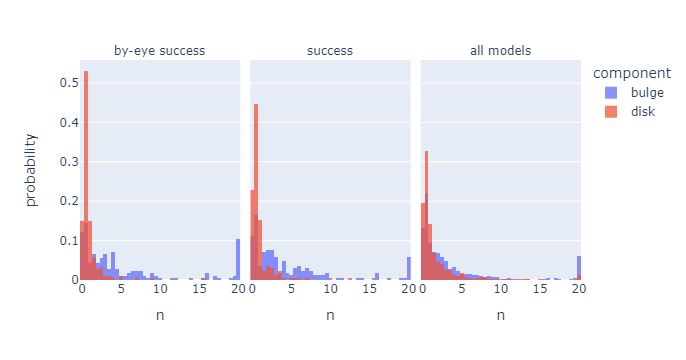

<Figure size 640x480 with 0 Axes>

In [205]:
x1   = "sersic_index_sersic_1"
x2   = "sersic_index_sersic_2"
x    = "n"
fcol = "domain"

# By eye success
plot_df = by_eye_success_df[[x1,x2]].rename(columns = {x1 : "bulge", x2 : "disk"})
plot_df = pd.melt(plot_df).rename(columns = {"value" : x, "variable" : "component"})
plot_df[fcol] = "by-eye success"

plot_df1 = success_df[[x1,x2]].rename(columns = {x1 : "bulge", x2 : "disk"})
plot_df1 = pd.melt(plot_df1).rename(columns = {"value" : x, "variable" : "component"})
plot_df1[fcol] = "success"

plot_df2 = full_df[[x1,x2]].rename(columns = {x1 : "bulge", x2 : "disk"})
plot_df2 = pd.melt(plot_df2).rename(columns = {"value" : x, "variable" : "component"})
plot_df2[fcol] = "all models"

plot_df = pd.concat([plot_df, plot_df1, plot_df2], axis = 0)

_ = create_plot(
    x           = x,
    runname     = "1000_by-eye-vs-success-vs-all",
    plot_type   = "histogram",
    df          = plot_df,
    histnorm    = "probability",
    color       = "component",
    nbins       = 40,
    facet_col   = fcol,
    #xaxis_range = [10, 17],
    #yaxis_range = [0, 1],
    # title       = f"{runname} galaxies: distribution of magnitudes for by-eye successful models"
    # title_y     = 0.85
    show        = True,
    write       = True
)

# _ = create_plot(
#     x           = x,
#     runname     = "1000_by-eye",
#     plot_type   = "histogram",
#     df          = plot_df,
#     color       = "component",
#     # title       = f"{runname} galaxies: distribution of Sérsic indices for by-eye successful models"
#     # title_y     = 0.85
#     show        = show
# )

# # All results
# plot_df = full_df[[x1,x2]].rename(columns = {x1 : "bulge", x2 : "disk"})
# plot_df = pd.melt(plot_df).rename(columns = {"value" : x, "variable" : "component"})

# _ = create_plot(
#     x           = x,
#     runname     = "1000",
#     plot_type   = "histogram",
#     df          = plot_df,
#     color       = "component",
#     # title       = f"{runname} galaxies: distribution of Sérsic indices for by-eye successful models"
#     # title_y     = 0.85
#     show        = show
# )

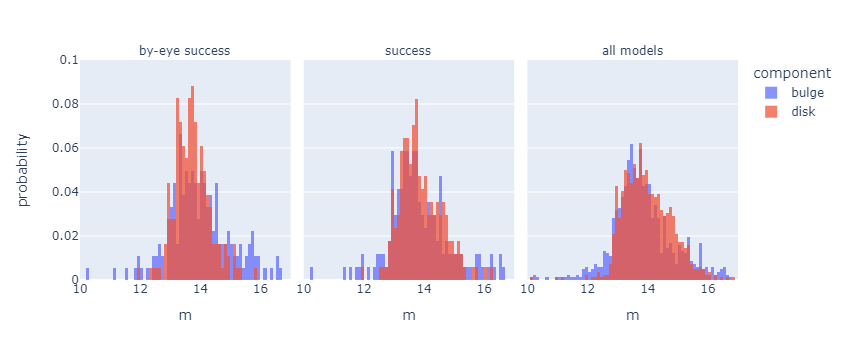

<Figure size 640x480 with 0 Axes>

In [202]:
# TODO: Combine these into one plot either using facet or go
# https://plotly.com/python/subplots/
# or https://plotly.com/python/facet-plots/

x1   = "magnitude_sersic_1"
x2   = "magnitude_sersic_2"
x    = "m"
fcol = "domain"

plot_df = by_eye_success_df[[x1,x2]].rename(columns = {x1 : "bulge", x2 : "disk"})
plot_df = pd.melt(plot_df).rename(columns = {"value" : x, "variable" : "component"})
plot_df[fcol] = "by-eye success"

plot_df1 = success_df[[x1,x2]].rename(columns = {x1 : "bulge", x2 : "disk"})
plot_df1 = pd.melt(plot_df1).rename(columns = {"value" : x, "variable" : "component"})
plot_df1[fcol] = "success"

plot_df2 = full_df[[x1,x2]].rename(columns = {x1 : "bulge", x2 : "disk"})
plot_df2 = pd.melt(plot_df2).rename(columns = {"value" : x, "variable" : "component"})
plot_df2[fcol] = "all models"

plot_df = pd.concat([plot_df, plot_df1, plot_df2], axis = 0)

_ = create_plot(
    x           = x,
    runname     = "1000_by-eye-vs-success-vs-all",
    plot_type   = "histogram",
    df          = plot_df,
    histnorm    = "probability",
    color       = "component",
    facet_col   = fcol,
    xaxis_range = [10, 17],
    yaxis_range = [0, 0.1],
    # title       = f"{runname} galaxies: distribution of magnitudes for by-eye successful models"
    # title_y     = 0.85
    show        = show,
    write       = True
)

# By eye
# figure1 = create_plot(
#     x           = x,
#     runname     = "1000_by-eye",
#     plot_type   = "histogram",
#     df          = plot_df,
#     color       = "component",
#     xaxis_range = [10, 17],
#     # title       = f"{runname} galaxies: distribution of magnitudes for by-eye successful models"
#     # title_y     = 0.85
#     show        = show,
#     write       = False
# )

# # All results
# plot_df = full_df[[x1,x2]].rename(columns = {x1 : "bulge", x2 : "disk"})
# plot_df = pd.melt(plot_df).rename(columns = {"value" : x, "variable" : "component"})

# figure2 = create_plot(
#     x           = x,
#     runname     = "1000",
#     plot_type   = "histogram",
#     df          = plot_df,
#     color       = "component",
#     xaxis_range = [10, 18],
#     # title       = f"{runname} galaxies: distribution of magnitudes for by-eye successful models"
#     # title_y     = 0.85
#     show        = show,
#     write       = False
# )

In [121]:
_ = create_plot(
    x           = "alen_ratio",
    runname     = "1000",
    plot_type   = "histogram",
    df          = full_df,
    xaxis_title = "alen ratio",
    multi       = False,
    # title       = f"{runname} galaxies: distribution of alen ratios for all models"
    # title_y     = 0.85
    show        = show
)

<Figure size 640x480 with 0 Axes>

In [122]:
_ = create_plot(
    x           = method,
    runname     = "1000_by-eye",
    plot_type   = "ecdf",
    df          = by_eye_success_df,
    xaxis_title = "KStest+NMR",
    add_hline   = False,
    # title       = f"1000 galaxies: ECDF for KStest+NMR on by-eye successful model fits",
    # title_y     = 0.92
    show        = show
)

<Figure size 640x480 with 0 Axes>

In [123]:
x     = "observation"
y     = "model"
color = "difference"

pre_pa  = full_df[["pre_pa1", "pre_pa2"]].mean(axis = 1)
post_pa = full_df[["post_pa1", "post_pa2"]].mean(axis = 1)
plot_df = pd.concat([pre_pa, post_pa], axis = 1).rename(columns = {0 : x, 1 : y})
plot_df[color] = abs(plot_df[x] - plot_df[y])

_ = create_plot(
    x         = x,
    y         = y,
    runname   = "1000_pa_diff",
    plot_type = "scatter",
    df        = plot_df,
    color     = color,
    # title     = "Pitch angle difference reported by SpArcFiRe, model vs observation"
    # title_y   = 0.85
    show      = show
)

<Figure size 640x480 with 0 Axes>

In [124]:
_ = create_plot(
    x           = "pa_diff_galaxy",
    runname     = "1000",
    plot_type   = "ecdf",
    df          = full_df,
    xaxis_title = "Pitch Angle Difference (deg)",
    cutoff_val  = 10,
    # title       = f"ECDF of pitch angle difference reported by SpArcFiRe, model vs observation"
    # title_y     = 0.85
    show        = show
)

<Figure size 640x480 with 0 Axes>

In [ ]:
x = "pa_diff_galaxy_nmr-metric"
runname = "1000_random"
plot_type = "scatter"
filetype = "png"

fig = px.scatter(
    by_eye_success_df,
    x = method, 
    y = "min_pa_diff",
    #color = "chiral_agreement",
    hover_data = {'Galaxy ID': (":c", by_eye_success_df.index)},
    log_x = True,
    title = "Minimum Pitch Angle Difference (pre/post GALFIT) vs Residual Metric"
)

fig.show()
#fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")
# Alternatively, call:
# fig.update_traces(marker=dict(color=color, size=size, symbol=symbol))

In [ ]:
x = "pa_diff_galaxy_nmr-metric"
runname = "1000_random"
plot_type = "scatter"
filetype = "png"

fig = px.scatter(
    full_df,
    x = method, 
    y = "pa_diff2",
    color = "chiral_agreement",
    hover_data = {'Galaxy ID': (":c", full_df.index)},
    log_x = True,
    title = "Other Pitch Angle Difference (pre/post GALFIT) vs Metric"
)

fig.show()
#fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")
# Alternatively, call:
# fig.update_traces(marker=dict(color=color, size=size, symbol=symbol))

In [ ]:
x = "pa_diff_galaxy_nmr-metric"
runname = "1000_random"
plot_type = "scatter"
filetype = "png"

fig = px.scatter(
    full_df,
    x = method, 
    y = "alen_ratio",
    color = "chiral_agreement",
    hover_data = {'Galaxy ID': (":c", full_df.index)},
    log_x = True,
    title = "Arm length ratio vs Metric"
)

fig.show()
#fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")
# Alternatively, call:
# fig.update_traces(marker=dict(color=color, size=size, symbol=symbol))

In [ ]:
x = "pa_diff_galaxy_nmr-metric"
runname = "1000_random"
plot_type = "scatter"
filetype = "png"

fig = px.scatter(
    full_df,
    x = "pa_diff1", 
    y = "alen_ratio",
    color = "chiral_agreement",
    hover_data = {'Galaxy ID': (":c", full_df.index)},
    #log_x = True,
    title = "Smallest Pitch Angle Difference (pre/post GALFIT) vs Arm Length Ratio"
)

fig.show()
#fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")
# Alternatively, call:
# fig.update_traces(marker=dict(color=color, size=size, symbol=symbol))

In [ ]:
# x = "pa_diff_galaxy_nmr-metric"
# runname = "1000_random"
# plot_type = "scatter"
# filetype = "png"

# #horizontal fit quality
# #vertical diff between pitch angles
# top_left_galaxies  = ["1237671122685329860", "1237680240907124849", "1237671122684215650", "1237668292835999800", "1237668272449257477"]
# bot_right_galaxies = ["1237674289682055597", "1237671261208576242", "1237668271907340482", "1237668623557263499", "1237668297681928386"]

# #plot_df = old_plot_df

# tl_to_mark = np.array([(plot_df.loc[gname, method], plot_df.loc[gname, "pa_diff_galaxy"]) for gname in top_left_galaxies])
# br_to_mark = np.array([(plot_df.loc[gname, method], plot_df.loc[gname, "pa_diff_galaxy"]) for gname in bot_right_galaxies])

# fig = px.scatter(
#     plot_df,
#     x = method, 
#     y = "pa_diff_galaxy", 
#     hover_data = {'Galaxy ID': (":c", plot_df.index)},
#     log_x = True,
#     title = "Pitch Angle Difference (pre/post GALFIT) vs Metric"
# )

# fig.add_trace(
#     go.Scatter(
#         x      = tl_to_mark[:,0], 
#         y      = tl_to_mark[:,1],
#         showlegend = False,
#         mode   = 'markers',
#         marker = dict(
#             line   = dict(width = 2),
#             symbol = 'circle-open',
#             size   = 15
#         )
#     )
#  )

# fig.add_trace(
#     go.Scatter(
#         x      = br_to_mark[:,0], 
#         y      = br_to_mark[:,1],
#         showlegend = False,
#         mode   = 'markers',
#         marker = dict(
#             line   = dict(width = 2),
#             symbol = 'circle-open',
#             size   = 15
#         )
#     )
#  )

# fig.show()
# #fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")
# # Alternatively, call:
# # fig.update_traces(marker=dict(color=color, size=size, symbol=symbol))

In [ ]:
for gname in bot_right_galaxies:
    print(f"cp {gname}/*-J_logSpiralArcs* ../for_pres && ", end = "")
          #&& cp {gname}/*_combined.png ../for_pres && ", end = "")
    #print(f"cp {gname[-3:]}/{gname}/*-J_logSpiralArcs* ~/29k_galaxies/for_pres ", end = "&& ")

In [ ]:
# x = "pre-post-pa_diff"
# runname = "1000_random"
# plot_type = "scatter"
# filetype = "png"

# fig = px.scatter(galfit_success, 
#            x = "pre_pa", 
#            y = "post_pa", 
#            #color = "pa_diff_galaxy", 
#            #text = galfit_success.index, 
#            hover_data = {'Galaxy ID': (":c", galfit_success.index)},
#            color_continuous_scale = "Agsunset"
#                 )

# # fig.update_annotations(
# #     clicktoshow = "onoff"
# # )
# fig.show()
# fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
x = "pre_post-1"
runname = "1000_random"
plot_type = "scatter"
filetype = "png"

fig = px.scatter(galfit_success, 
           x = "pre_pa1", 
           y = "post_pa1", 
           #color = "pa_diff_galaxy", 
           #text = galfit_success.index, 
           hover_data = {'Galaxy ID': (":c", galfit_success.index)},
           color_continuous_scale = "Agsunset"
                )

# fig.update_annotations(
#     clicktoshow = "onoff"
# )
fig.show()
#fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
x = "pre_post-2"
runname = "1000_random"
plot_type = "scatter"
filetype = "png"

fig = px.scatter(galfit_success, 
           x = "pre_pa2", 
           y = "post_pa2", 
           #color = "pa_diff_galaxy", 
           #text = galfit_success.index, 
           hover_data = {'Galaxy ID': (":c", galfit_success.index)},
           color_continuous_scale = "Agsunset"
                )

# fig.update_annotations(
#     clicktoshow = "onoff"
# )
fig.show()
#fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
x = "pa_diffs"
runname = "1000_random"
plot_type = "scatter"
filetype = "png"

fig = px.scatter(galfit_success, 
           x = "pa_diff1", 
           y = "pa_diff2", 
           #color = "pa_diff_galaxy", 
           #text = galfit_success.index, 
           hover_data = {'Galaxy ID': (":c", galfit_success.index)},
           color_continuous_scale = "Agsunset"
                )

# fig.update_annotations(
#     clicktoshow = "onoff"
# )
fig.show()
#fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
sum((full_df["pa_diff1"] < 15) | (full_df["pa_diff2"] < 15))

In [ ]:
reduced_full_df = full_df.dropna().sort_values(method)[(full_df["pa_diff1"] < 15) | (full_df["pa_diff2"] < 15)]

In [ ]:
sum(reduced_full_df[method] < 0.007)

In [ ]:
reduced_full_df

In [ ]:
print(len(all_sparc_output.dropna()), len(galfit_success), sum(plot_df.loc[:, "pa_diff_galaxy"] < 15))

In [ ]:
#print(sum(galfit_success.loc[:, "within_15_degrees_pre"]), sum(galfit_success.loc[:, "within_15_degrees_post"]))

In [ ]:
#pitch angle
#min((a1-b1) + (a2-b2))

In [ ]:
x = "diff_sparcfire"
runname = "1000_random"
plot_type = "ecdf"
filetype = "png"
#y = "count"
fig = px.ecdf(plot_df, 
              x = x,
              #y = y,
        title = "Pitch Angle Difference reported by SpArcFiRe on an observation vs GALFIT model",
        markers = True, 
        lines = False, 
        #facet_col = "Run ", 
        marginal = "histogram",
        ecdfnorm = None,
        labels = {
                  x : "Pitch Angle Difference (deg)"#,
                  #y : y.capitalize()
                 }
       )

cutoff_diff = 15 #1
fig.add_vline(x = cutoff_diff,
              row = 1,
              line_color = "black",
              opacity = 0.5#,
              #annotation_text= f"{cutoff_diff}", 
              #annotation_position="bottom"
             )

fig.add_hline(y = sum(plot_df.loc[:, "diff_sparcfire"] < 15),
              row = 1,
              line_color = "black",
              opacity = 0.5,
              annotation_text= f"{sum(plot_df.loc[:, 'diff_sparcfire'] < 15)}", 
              annotation_position="left"
             )

# fig.update_layout({
#     'plot_bgcolor': 'rgba(0,0,0,0)',
#     'paper_bgcolor': 'rgba(0,0,0,0)'
# })


fig.show()
fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
# x = "diff_pre"
# runname = "1000_random"
# plot_type = "ecdf"
# #y = "count"
# fig = px.ecdf(galfit_success, 
#               x = x,
#               #y = y,
#         title = "Pitch Angle Difference between SpArcFiRe and GALFIT (observation vs model) on eligible spiral fits",
#         markers = True, 
#         lines = False, 
#         #facet_col = "Run ", 
#         marginal = "histogram",
#         ecdfnorm = None,
#         labels = {
#                   x : "Pitch Angle Difference (deg)"#,
#                   #y : y.capitalize()
#                  }
#        )

# cutoff_diff = 15 #1
# fig.add_vline(x = cutoff_diff,
#               row = 1,
#               line_color = "black",
#               annotation_text= f"{cutoff_diff}", 
#               annotation_position="bottom")

# fig.show()
# fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
# x = "diff_post"
# plot_type = "ecdf"
# fig = px.ecdf(galfit_success, x = x,
#               title = "Pitch Angle Difference between SpArcFiRe and GALFIT (model vs model) on eligible spiral fits",
#               markers = True, 
#               lines = False, 
#               #facet_col = "Run ", 
#               marginal = "histogram",
#               ecdfnorm = None,
#               labels = {
#                         x : "Pitch Angle Difference (deg)"
#                        }
#              )

# fig.add_vline(x = cutoff_diff,
#               row = 1,
#               line_color = "black",
#               annotation_text= f"{cutoff_diff}", 
#               annotation_position="bottom")

# fig.show()
# fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
# x = "pre_pa"
# y = "avg_pitch_angle"
# color = "within_15_degrees_pre"
# plot_type = "scatter"
# fig = px.scatter(galfit_success, 
#                  x = x,
#                  y = y,
#                  color = color,
#                  title = "Pitch Angle Difference between SpArcFiRe and GALFIT (observation vs model) on eligible spiral fits",
#                  #hover_data = ["Galaxy_Name"],
#                  labels= {
#                      x : "SpArcFiRe Pitch Angle (deg)",
#                      y : "GALFIT Pitch Angle (deg)",
#                      color : "Within 15 Degrees"#,
#                      #"Galaxy_Name" : "Galaxy Name"
#                          }
#                 )

# # fig.update_layout({
# #                    "plot_bgcolor": "rgba(0, 0, 0, 0)"#,
# #                    #"paper_bgcolor": "rgba(0, 0, 0, 0)",
# #                   })

# fig.show()
# fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
# x = "post_pa"
# y = "avg_pitch_angle"
# color = "within_15_degrees_post"
# plot_type = "scatter"
# fig = px.scatter(galfit_success, 
#                  x = x,
#                  y = y,
#                  color = color,
#                  title = "Pitch Angle Difference between SpArcFiRe and GALFIT (model vs model) on eligible spiral fits",
#                  #hover_data = ["Galaxy_Name"],
#                  labels= {
#                      x : "SpArcFiRe Pitch Angle (deg)",
#                      y : "GALFIT Pitch Angle (deg)",
#                      color : "Within 15 Degrees"#,
#                      #"Galaxy_Name" : "Galaxy Name"
#                          }
#                 )

# # fig.update_layout({
# #                    "plot_bgcolor": "rgba(0, 0, 0, 0)"#,
# #                    #"paper_bgcolor": "rgba(0, 0, 0, 0)",
# #                   })

# fig.show()
# fig.write_image(f"{plot_type}_{runname}_{x}.{filetype}")

In [ ]:
def generate_images_old(input_df, png_dir:str, variable_name:str, custom_range = None):
    images_out = []
    
    if not custom_range:
        custom_range = range(0, len(input_df), 50) 
        
    count = 0
    for index_num in custom_range:
        g_variable = input_df.iloc[index_num]
        gname = g_variable.name
        variable_value = g_variable[variable_name]#.norm_masked_residual

        height = 500
        width = 500
        size = (height, width)
        #out_str = galaxy_info.name.replace("galfit_out.fits", "combined.png").strip()
        out_str = f"{gname}_combined.png"
        #print(out_str)
        
        
        images_out.append(Image(filename = pj(png_dir, out_str), width=width, height=height))
            
        print(f"{gname}, sorted #: {index_num}")
        print(f"{variable_name} = {variable_value:.6f}")
        #print(f"Dim: {galaxy_info['image_size']}x{galaxy_info['image_size']}")
        print()
        
    return images_out

In [ ]:
images_to_disp = generate_images_old(full_df, pj(out_dir, "galfit_png"), "diff") #, range(0,len(full_df)))

In [ ]:
display(*images_to_disp)

In [ ]:
run_name = "Testing"
analysis_var = "nmr_x_1-p" #"KS_P" 
#residual_df.sort_values(by = [analysis_var], inplace = True)
plot_df.sort_values(by = ["nmr_x_1-p"], inplace = True) # "diff_pre_post"

In [ ]:
# fail_df = deepcopy(residual_df.query(f"{analysis_var} > {cutoff_val}"))
# fail_df.sort_values(by = [nmr], inplace = True)
#fail_df

In [ ]:
graphing_df = pd.DataFrame()
# graphing_df[run2_name] = nmr2_lim[nmr]
# graphing_df[run6_name] = nmr6_lim[nmr]
#graphing_df[run_name] = nmr_lim[nmr]
graphing_df[run_name] = residual_df[analysis_var]

In [ ]:
#graphing_df = graphing_df.melt(id_vars = [], value_vars = [run2_name, run6_name], var_name = "Run ", value_name = nmr, ignore_index = False)
#graphing_df = graphing_df.melt(id_vars = [], value_vars = [run_name], var_name = "Run ", value_name = nmr, ignore_index = False)
graphing_df = graphing_df.melt(id_vars = [], value_vars = [run_name], var_name = "Run ", value_name = analysis_var, ignore_index = False)

In [ ]:
# fig = px.ecdf(graphing_df, 
#               #x = nmr,
#               x = analysis_var,
#               markers = True, 
#               lines = False, 
#               #facet_col = "Run ", 
#               marginal = "histogram",
#               title = f"ECDF for kstest by {analysis_var}"
#              ) #, facet_col_wrap = 1) # 

# # yval = 0.79
# # fig.add_hline(y = yval, 
# #               row = 1,
# #               col = 1,
# #               line_color = "magenta",
# #               annotation_text=f"{yval}", #from Run7", 
# #               annotation_position="left")

# # fig.add_hline(y = 0.69,
# #               row = 1,
# #               col = 2,
# #               line_color = "cyan",
# #               annotation_text="0.78", # from Run6", 
# #               annotation_position="right")

# # cutoff_val = 0.95 #1
# # fig.add_vline(x = cutoff_val, 
# #               row = 1,
# #               line_color = "black",
# #               annotation_text= f"{cutoff_val}", 
# #               annotation_position="bottom")

# # fig.add_trace(go.Scatter(x = np.ones(len(nmr2_lim))*0.004, y = np.linspace(0,1,num = len(nmr2_lim)), mode = "lines"))
# # fig.add_trace(go.Scatter(x = np.linspace(0.002, 0.01, num = len(nmr2_lim)), y = np.ones(len(nmr2_lim))*0.75, mode = "lines"))

# # fig.add_trace(go.Scatter(x = np.ones(len(nmr2_lim))*0.004, y = np.linspace(0,1,num = len(nmr2_lim))))
# # fig.add_trace(go.Scatter(x = np.linspace(0.002, 0.01, num = len(nmr2_lim)), y = np.ones(len(nmr2_lim))*0.75))


# fig.show()

In [ ]:
# #cutoff_val_old = 0.0063
# total_gal = 1000
# # Old is with smaller fitting region
# # new is larger fitting region for better(?) sky estimation

# run_name = run_name.strip()

# print(f"Total number of galaxies attempted: {total_gal}")
# print()
# print(f"Number of Galfit models generated...")
# #print(f"{run2_name} : {len(norms2_df)}/{total_gal}")
# #print(f"{run6_name}: {len(norms6_df)}/{total_gal}")
# print(f"{run_name}: {len(residual_df)}/{total_gal}, {100*len(residual_df)/total_gal:.2f}%")
# #print(f"Old {run_name}: {len(old_df)}/{total_gal}, {100*len(old_df)/total_gal:.2f}%")

# cutoff = residual_df.query(f"{analysis_var} < {cutoff_val}")
# #cutoff_old = old_df.query(f"{analysis_var} < {cutoff_val_old}")
# print()
# print(f"Residuals below {cutoff_val} cutoff")
# print(f"{run_name}: {len(cutoff)}/{len(residual_df)}, {100*len(cutoff)/len(residual_df):.2f}%")
# #print(f"Old {run_name}: {len(cutoff_old)}/{len(old_df)}, {100*len(cutoff_old)/len(residual_df):.2f}%")
# # print()
# # print(f"Residuals below {cutoff_val} cutoff (excluding obscene failures)...")
# # print(f"{run_name}: {len(cutoff)}/{len(graphing_df)}, {100*len(cutoff)/len(graphing_df):.2f}%")

In [ ]:
def generate_images(input_df, png_dir:str, cutoff_val = 0.01, variable_name = "norm_masked_residual", custom_range = None):
    images_below_cutoff = []
    images_above_cutoff = []
    
    if not custom_range:
        custom_range = range(0, len(input_df), 50) 
    count = 0
    for index_num in custom_range:
        g_variable = input_df.iloc[index_num]
        gname = g_variable.name
        variable_value = g_variable[variable_name]#.norm_masked_residual

        # iloc returns a series, name returns the name of the row

        
        # print(f"chi^2/nu = {galaxy_info['chi^2_nu']:.2f}")
        # print(f"chi^2 = {galaxy_info['chi^2']:.2f}")
        #print(f"Norm GALFIT residual = {norm_galfit_residual:.4f}")


        # galfit_cmap = grayscale_cmap('RdBu')
        # residual_plot = plt.imshow(np.flipud(masked_residual[:,:])) #, norm=colors.LogNorm())
        # residual_plot.set_cmap('Greys')
        # residual_plot.set_cmap(galfit_cmap)
        # cbar = plt.colorbar()

        #plt.imshow(residual_plot)
        #imgplot = plt.imshow(arr[:, :, 0])
        height = 500
        width = 500
        size = (height, width)
        #out_str = galaxy_info.name.replace("galfit_out.fits", "combined.png").strip()
        out_str = f"{gname}_combined.png"
        #print(out_str)
        
        if variable_value < cutoff_val:
            images_below_cutoff.append(Image(filename = pj(png_dir, out_str), width=width, height=height))
            #images_below_cutoff.append(PIL.Image.open(pj(png_dir, out_str)).resize(size))
        else:
            count += 1
            if count == 1:
                print("="*80)
            images_above_cutoff.append(Image(filename = pj(png_dir, out_str), width=width, height=height))
            #images_above_cutoff.append(PIL.Image.open(pj(png_dir, out_str)).resize(size))

            
        print(f"{gname}, sorted #: {index_num}")
        print(f"{variable_name} = {variable_value:.6f}")
        #print(f"Dim: {galaxy_info['image_size']}x{galaxy_info['image_size']}")
        print()
        
    return images_below_cutoff, images_above_cutoff

In [ ]:
check_df = residual_df[residual_df.index.isin(vals_to_check)]

In [ ]:
check_df

In [ ]:
png_dir = os.path.join(run_path, out_dir, "galfit_png")
#below, above = generate_images(plot_df, png_dir, cutoff_val = 0.007, variable_name = analysis_var, custom_range = range(600, len(plot_df), 5) )
below, above = generate_images(full_df.sort_values(method), png_dir, cutoff_val = 0.007, variable_name = method, custom_range = range(850, len(full_df), 5) )
#below, above = generate_images(check_df, png_dir, cutoff_val = cutoff_val, variable_name = analysis_var, custom_range = range(0, len(check_df), 5) )

In [ ]:
display(*below)

In [ ]:
display(*above)

In [ ]:
png_dir = os.path.join(run_path, out_dir, "galfit_png")
#below, above = generate_images(residual_df, png_dir, cutoff_val = 0.013342, variable_name = analysis_var, custom_range = range(700, len(residual_df), 10) )
below, above = generate_images(residual_df, png_dir, cutoff_val = cutoff_val, variable_name = analysis_var, custom_range = range(800, len(residual_df), 10) )

In [ ]:
display(*below)

In [ ]:
display(*above)

In [ ]:
png_dir = os.path.join(run_path, out_dir, "galfit_png")
below, above = generate_images(fail_df, png_dir, cutoff_val = 1, variable_name = nmr)#, custom_range = range(650, len(residual_df), 30) )

In [ ]:
display(*below)

In [ ]:
display(*above)

In [ ]:
# gname = "1237671266033992029"
# print(residual_df.loc[gname,:])
# #gname_file = pj(out_dir, gname, f"{gname}_galfit_out.fits")
# gname_file = pj(tmp_dir, "galfits", f"{gname}_galfit_out.fits")
# # # #print(gname_file)
# gname_fit = OutputFits(gname_file)
# mask = FitsFile(pj(tmp_dir, "galfit_masks", f"{gname}_star-rm.fits"))
# gname_fit.generate_masked_residual(mask, use_bulge_mask = True)
# #print(gname_fit.nmr)
# print(1 - gname_fit.kstest.pvalue)
# #print(gname_fit.feedme) #.param_values.get("skip", 0))#.path_to_feedme)

In [ ]:
# https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o
# Could also be useful https://eltos.github.io/gradient/#FFFFFF-A5A5A5-000000-A5A5A5-FFFFFF
# png_dir6 = os.path.join(run_path6, sparc_out, galfit_out, "galfit_png/")
# images_below_cutoff, images_above_cutoff = generate_images(norms6_df, png_dir6, cutoff = 0.1)
png_dir = os.path.join(run_path, out_dir, "galfit_png")
#images_below_cutoff, images_above_cutoff = generate_images(norms7_df, png_dir7, cutoff = 0.8)
below, above = generate_images(norms_df, png_dir, cutoff_val = cutoff_val, custom_range = range(800, len(norms_df)-10, 5))

In [ ]:
gname = "1237667431169916984_out.fits"
gname_fits = OutputFits(gname) #OutputFits(pj(out_dir, gname, gname + "_galfit_out.fits"))
print(gname_fits.feedme)

In [ ]:
good_fit = "1237671262278582530"
bad_fit = "1237668366388756890"

good_fit_obj = OutputFits(pj(out_dir, good_fit, f"{good_fit}_galfit_out.fits"))
bad_fit_obj = OutputFits(pj(out_dir, bad_fit, f"{bad_fit}_galfit_out.fits"))
good_residual = good_fit_obj.residual.data

scipy.stats.probplot(good_residual.flatten(), plot = plt)

In [ ]:
bad_residual = bad_fit_obj.residual.data
scipy.stats.probplot(bad_residual.flatten(), plot = plt)

In [ ]:
size_sorted2 = norms2_df.sort_values(by=['image_size'])[::-1]
size_sorted6 = norms6_df.sort_values(by=['image_size'])[::-1]

In [ ]:
png_dir2 = os.path.join(run_path2, sparc_out, galfit_out, "galfit_png/")
top_10_by_size2, _ = generate_images(size_sorted2, png_dir2, cutoff = 0.004, custom_range = range(10))
print("=============================================\n")
top_10_by_size6, _ = generate_images(size_sorted6, png_dir6, cutoff = 0.004, custom_range = range(10))

In [ ]:
display(*top_10_by_size6)

In [ ]:
# Grab top 1000 highest resolution galaxies from Darren's 27K and run this on those
# Change pitch angle plotting to only plot sparcfire's line between r_in and r_out and see how that compare to galfit
# Tile residuals for presentation???

In [ ]:
# Thanks to https://jakevdp.github.io/PythonDataScienceHandbook/04.07-customizing-colorbars.html
def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)